# Load Data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pathlib import Path

In [2]:
# Load all AA SNPs into one dataframe

data_dir = Path('../data').resolve()
aa_snp_files = sorted((data_dir / 'aa_snp').glob('*.csv'))
aa_snp_files

[PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0101-0131_aa_snp.csv'),
 PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0201-0229_aa_snp.csv'),
 PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0301-0331_aa_snp.csv'),
 PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0401-0407_aa_snp.csv'),
 PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0408-0414_aa_snp.csv'),
 PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0415-0421_aa_snp.csv'),
 PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0422-0430_aa_snp.csv'),
 PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0501-0507_aa_snp.csv'),
 PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0508-0514_aa_snp.csv'),
 PosixPath('/Volumes/GoogleDrive/My Drive/covid_data/aa_snp/gisaid_0515-0519_aa_snp.csv')]

In [3]:
aa_snp_df = pd.DataFrame()

for f in aa_snp_files:
    print(f.name)
    aa_snp_df = pd.concat([
        aa_snp_df,
        pd.read_csv(f)
    ], ignore_index=True)

aa_snp_df

gisaid_0101-0131_aa_snp.csv
gisaid_0201-0229_aa_snp.csv
gisaid_0301-0331_aa_snp.csv
gisaid_0401-0407_aa_snp.csv
gisaid_0408-0414_aa_snp.csv
gisaid_0415-0421_aa_snp.csv
gisaid_0422-0430_aa_snp.csv
gisaid_0501-0507_aa_snp.csv
gisaid_0508-0514_aa_snp.csv
gisaid_0515-0519_aa_snp.csv


,taxon,gene,pos,ref,alt
0,hCoV-19/Wuhan/WH04/2020|EPI_ISL_406801|2020-01-05,ORF8,83,L,S
1,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,S,246,S,R
2,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,ORF3a,250,G,V
3,hCoV-19/Germany/BavPat1/2020|EPI_ISL_406862|20...,S,613,D,G
4,hCoV-19/USA/WA1/2020|EPI_ISL_404895|2020-01-19,ORF8,83,L,S
...,...,...,...,...,...
125392,hCoV-19/USA/MI-MDHHS-SC20282/2020|EPI_ISL_4470...,ORF3a,56,Q,H
125393,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1a,264,T,I
125394,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1b,313,P,L
125395,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,S,613,D,G


# SNP Frequency

Which SNPs are most common? Is the distribution bimodal and can we effectively partition real SNPs vs. sequencing/PCR errors?

In [4]:
snp_count_df = (
    aa_snp_df
    .groupby(['gene', 'pos', 'ref', 'alt'], as_index=False)
    .count()
    .rename(columns={'taxon': 'count'})
)
snp_count_df

,gene,pos,ref,alt,count
0,E,4,V,I,1
1,E,5,S,L,1
2,E,6,E,D,1
3,E,6,E,Q,1
4,E,8,T,I,7
...,...,...,...,...,...
11206,S,1263,V,L,7
11207,S,1264,L,P,1
11208,S,1265,K,R,2
11209,S,1272,T,I,2


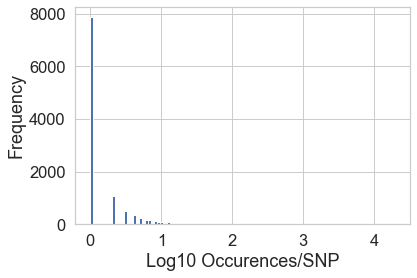

In [16]:
sns.set(style='whitegrid', font_scale=1.5)

fig, ax = plt.subplots(1, 1)

ax.hist(np.log10(snp_count_df['count']), bins=100)
ax.set_xlabel('Log10 Occurences/SNP')
ax.set_ylabel('Frequency')

plt.show()

Filtering out SNPs seen <= 3 times seems reasonable, that's the majority of the density here. We want to keep it relatively low since we want to be able to track rare or up-and-coming SNPs.

## Are some genes mutating more than others?

In [20]:
aa_snp_df.groupby('gene')['taxon'].count()

gene
E          242
M         1142
N        19080
ORF10      223
ORF1a    32670
ORF1b    30457
ORF3a    11924
ORF6       378
ORF7a      914
ORF7b      219
ORF8      3684
S        24464
Name: taxon, dtype: int64

Mostly correlates with gene size, except for Spike, which seems to be proportionally mutating more

# SNP Grouping

Are there coherent groupings of SNPs? Can we effectively create "signatures" of SNPs and classify taxons into them? Or is it gonna be messier than that?

If the groupings are coherent, then we should see clear clusters of taxons based on their shared SNPs.

Let's create a jaccard matrix, N x N, where N = number of taxons, and where the cell value is the jaccard distance, where

$$
\mathrm{Jaccard\,distance}(A,B) = 1 - \frac{|A \cap B|}{|A \cup B|}
$$

Actually, nvm... with 30K x 30K clades this creates ~1B comparisons, which is not good.

Instead let's try counting the occurence of SNPs together. Filter out SNPs with <= 3 overall occurences. Then group taxons by their set of SNPs, and look at the frequencies of those. If a lot of the density is at 1 or 2, then we'll have to rethink things

In [23]:
# Condense SNPs into one string that we can search over
aa_snp_df

,taxon,gene,pos,ref,alt
0,hCoV-19/Wuhan/WH04/2020|EPI_ISL_406801|2020-01-05,ORF8,83,L,S
1,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,S,246,S,R
2,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,ORF3a,250,G,V
3,hCoV-19/Germany/BavPat1/2020|EPI_ISL_406862|20...,S,613,D,G
4,hCoV-19/USA/WA1/2020|EPI_ISL_404895|2020-01-19,ORF8,83,L,S
...,...,...,...,...,...
125392,hCoV-19/USA/MI-MDHHS-SC20282/2020|EPI_ISL_4470...,ORF3a,56,Q,H
125393,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1a,264,T,I
125394,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1b,313,P,L
125395,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,S,613,D,G


In [29]:
aa_snp_df['snp_str'] = aa_snp_df['gene'].str.cat([
    aa_snp_df['pos'].astype(str), 
    aa_snp_df['ref'],
    aa_snp_df['alt']
], sep='|')
aa_snp_df

,taxon,gene,pos,ref,alt,snp_str
0,hCoV-19/Wuhan/WH04/2020|EPI_ISL_406801|2020-01-05,ORF8,83,L,S,ORF8|83|L|S
1,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,S,246,S,R,S|246|S|R
2,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,ORF3a,250,G,V,ORF3a|250|G|V
3,hCoV-19/Germany/BavPat1/2020|EPI_ISL_406862|20...,S,613,D,G,S|613|D|G
4,hCoV-19/USA/WA1/2020|EPI_ISL_404895|2020-01-19,ORF8,83,L,S,ORF8|83|L|S
...,...,...,...,...,...,...
125392,hCoV-19/USA/MI-MDHHS-SC20282/2020|EPI_ISL_4470...,ORF3a,56,Q,H,ORF3a|56|Q|H
125393,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1a,264,T,I,ORF1a|264|T|I
125394,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1b,313,P,L,ORF1b|313|P|L
125395,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,S,613,D,G,S|613|D|G


In [44]:
# Filter out SNPs
valid_snps = (
    snp_count_df
    .loc[snp_count_df['count'] > 3, :]
    .reset_index()
    [['gene', 'pos', 'ref', 'alt']]
    .applymap(str)
    .agg('|'.join, axis=1)
)
valid_snps

0          E|8|T|I
1         E|20|L|F
2         E|23|V|M
3         E|29|T|A
4         E|29|T|I
           ...    
1752    S|1258|D|H
1753    S|1259|D|N
1754    S|1262|P|L
1755    S|1263|V|L
1756    S|1273|_|*
Length: 1757, dtype: object

In [48]:
aa_snp_filt_df = aa_snp_df.loc[
    aa_snp_df['snp_str'].isin(valid_snps.values),
    :
].reset_index()
aa_snp_filt_df

,index,taxon,gene,pos,ref,alt,snp_str
0,0,hCoV-19/Wuhan/WH04/2020|EPI_ISL_406801|2020-01-05,ORF8,83,L,S,ORF8|83|L|S
1,2,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,ORF3a,250,G,V,ORF3a|250|G|V
2,3,hCoV-19/Germany/BavPat1/2020|EPI_ISL_406862|20...,S,613,D,G,S|613|D|G
3,4,hCoV-19/USA/WA1/2020|EPI_ISL_404895|2020-01-19,ORF8,83,L,S,ORF8|83|L|S
4,5,hCoV-19/Shenzhen/HKU-SZ-005/2020|EPI_ISL_40583...,ORF1a,3098,S,L,ORF1a|3098|S|L
...,...,...,...,...,...,...,...
113667,125392,hCoV-19/USA/MI-MDHHS-SC20282/2020|EPI_ISL_4470...,ORF3a,56,Q,H,ORF3a|56|Q|H
113668,125393,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1a,264,T,I,ORF1a|264|T|I
113669,125394,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1b,313,P,L,ORF1b|313|P|L
113670,125395,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,S,613,D,G,S|613|D|G


In [58]:
# Group by taxon and make a ';' delimited list of snp_strs
aa_snp_filt_group_df = aa_snp_filt_df.groupby('taxon')['snp_str'].agg(';'.join).reset_index()
aa_snp_filt_group_df

,taxon,snp_str
0,hCoV-10/Canada/AB5/2020|EPI_ISL_435347|2020-04,ORF1b|313|P|L;S|613|D|G;ORF3a|13|T|I
1,hCoV-19/Algeria/G0638_2264/2020|EPI_ISL_418241...,ORF1a|264|T|I;ORF1b|313|P|L;ORF1b|1549|H|Y;S|6...
2,hCoV-19/Algeria/G0640_2265/2020|EPI_ISL_418242...,ORF1a|264|T|I;ORF1b|313|P|L;S|613|D|G;ORF3a|56...
3,hCoV-19/Algeria/G0860_2262/2020|EPI_ISL_420037...,ORF1a|264|T|I;ORF1a|1821|T|I;ORF1b|313|P|L;S|6...
4,hCoV-19/Anhui/SZ005/2020|EPI_ISL_413485|2020-0...,ORF1a|641|L|F;ORF1a|3605|L|F;ORF8|83|L|S
...,...,...
26571,hCoV-19/Yunnan/0306-466/2020|EPI_ISL_429239|20...,ORF1b|814|D|Y
26572,hCoV-19/Yunnan/IVDC-YN-003/2020|EPI_ISL_408480...,ORF1a|3605|L|F;ORF8|83|L|S
26573,hCov-19/Canada/AG1/2020|EPI_ISL_435344|2020-04,ORF1a|264|T|I;ORF1b|313|P|L;ORF1b|453|M|I;S|61...
26574,hCov-19/Canada/AG6/2020|EPI_ISL_435343|2020-04,ORF1a|264|T|I;ORF1b|313|P|L;S|613|D|G;ORF3a|56...


In [61]:
# Count occurences of SNP signatures and plot
snp_sig_count_df = aa_snp_filt_group_df.groupby('snp_str').count()
snp_sig_count_df

,taxon
snp_str,
E|67|S|C;ORF8|83|L|S;ORF8|118|D|E,3
E|67|S|C;ORF8|83|L|S;ORF8|118|D|E;ORF8|120|I|F,1
E|67|S|F;ORF7a|102|I|F,3
E|67|S|F;ORF8|83|L|S,1
M|208|D|H,6
...,...
S|674|Q|R;ORF3a|195|G|V;ORF8|83|L|S;N|196|S|L,1
S|70|S|F,1
S|730|M|I;ORF8|83|L|S,1


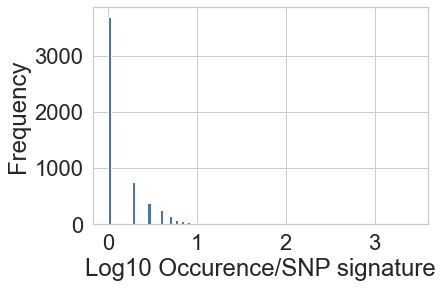

In [62]:
sns.set(style='whitegrid', font_scale=2)

fig, ax = plt.subplots(1, 1)

ax.hist(np.log10(snp_sig_count_df['taxon']), bins=100)
ax.set_xlabel('Log10 Occurence/SNP signature')
ax.set_ylabel('Frequency')

plt.show()

The majority of the density is at 1. Let's try a more stringent filtering of SNPs, this time at >5 total occurences.

In [63]:
# Filter out SNPs
valid_snps = (
    snp_count_df
    .loc[snp_count_df['count'] > 5, :]
    .reset_index()
    [['gene', 'pos', 'ref', 'alt']]
    .applymap(str)
    .agg('|'.join, axis=1)
)

snp_sig_count_df = (
    aa_snp_df.loc[aa_snp_df['snp_str'].isin(valid_snps.values), :]
    .reset_index()
    .groupby('taxon')['snp_str']
    .agg(';'.join)
    .reset_index()
    .groupby('snp_str')
    .count()
)
snp_sig_count_df

,taxon
snp_str,
E|67|S|F;ORF7a|102|I|F,3
E|67|S|F;ORF8|83|L|S,1
M|208|D|H,6
N|167|P|Q,1
N|184|R|C,1
...,...
S|654|H|Y;ORF8|83|L|S,1
S|70|S|F,1
S|730|M|I;ORF8|83|L|S,1


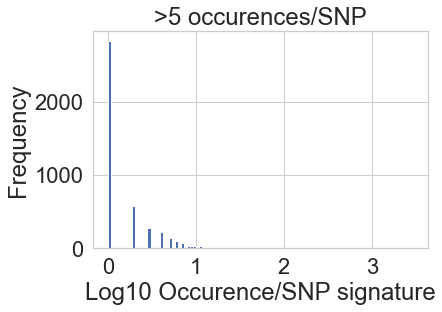

In [64]:
sns.set(style='whitegrid', font_scale=2)

fig, ax = plt.subplots(1, 1)

ax.hist(np.log10(snp_sig_count_df['taxon']), bins=100)
ax.set_xlabel('Log10 Occurence/SNP signature')
ax.set_ylabel('Frequency')
ax.set_title('>5 occurences/SNP')

plt.show()

A bit better but still not good...

# Filter out taxons

The SNP signature grouping didn't work well -- maybe it'll work better if we remove problematic sequences that have a lot of mutations


In [71]:
snps_per_taxon = aa_snp_df.groupby('taxon')['snp_str'].count()
# Filter out taxons with 0 SNPs
snps_per_taxon = snps_per_taxon[snps_per_taxon > 0]
snps_per_taxon

taxon
hCoV-10/Canada/AB5/2020|EPI_ISL_435347|2020-04               3
hCoV-19/Algeria/G0638_2264/2020|EPI_ISL_418241|2020-03-02    7
hCoV-19/Algeria/G0640_2265/2020|EPI_ISL_418242|2020-03-08    4
hCoV-19/Algeria/G0860_2262/2020|EPI_ISL_420037|2020-03-02    5
hCoV-19/Anhui/SZ005/2020|EPI_ISL_413485|2020-01-24           7
                                                            ..
hCoV-19/Yunnan/0306-466/2020|EPI_ISL_429239|2020-03-06       3
hCoV-19/Yunnan/IVDC-YN-003/2020|EPI_ISL_408480|2020-01-17    2
hCov-19/Canada/AG1/2020|EPI_ISL_435344|2020-04               7
hCov-19/Canada/AG6/2020|EPI_ISL_435343|2020-04               5
hCov-19/USA/CT-Yale-072/2020|EPI_ISL_428400|2020-03-30       4
Name: snp_str, Length: 26655, dtype: int64

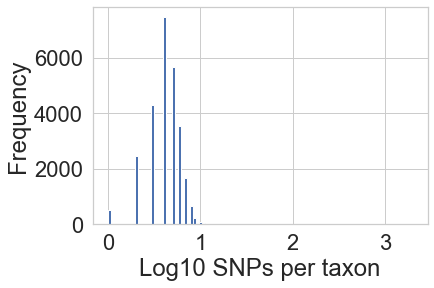

In [73]:
fig, ax = plt.subplots(1, 1)

ax.hist(np.log10(snps_per_taxon.values), bins=100)
ax.set_xlabel('Log10 SNPs per taxon')
ax.set_ylabel('Frequency')

plt.show()

This is actually quite reasonable - everything below 10 SNPs/taxon looks real actually. How many have >10 SNPs?

In [75]:
(snps_per_taxon > 10).sum()

116

## Grouping with filter on SNP frequency and highly-mutated taxons

Apply both of the filters, No taxons with >10 SNPs and SNP frequency > 3 across all taxons

In [76]:
aa_snp_df

,taxon,gene,pos,ref,alt,snp_str
0,hCoV-19/Wuhan/WH04/2020|EPI_ISL_406801|2020-01-05,ORF8,83,L,S,ORF8|83|L|S
1,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,S,246,S,R,S|246|S|R
2,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,ORF3a,250,G,V,ORF3a|250|G|V
3,hCoV-19/Germany/BavPat1/2020|EPI_ISL_406862|20...,S,613,D,G,S|613|D|G
4,hCoV-19/USA/WA1/2020|EPI_ISL_404895|2020-01-19,ORF8,83,L,S,ORF8|83|L|S
...,...,...,...,...,...,...
125392,hCoV-19/USA/MI-MDHHS-SC20282/2020|EPI_ISL_4470...,ORF3a,56,Q,H,ORF3a|56|Q|H
125393,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1a,264,T,I,ORF1a|264|T|I
125394,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1b,313,P,L,ORF1b|313|P|L
125395,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,S,613,D,G,S|613|D|G


In [85]:
snps_per_taxon = aa_snp_df.groupby('taxon')['snp_str'].count()
valid_taxons = snps_per_taxon.index[snps_per_taxon <= 10]

aa_snp_filt_df = aa_snp_df.loc[aa_snp_df['taxon'].isin(valid_taxons), :]
aa_snp_filt_df

,taxon,gene,pos,ref,alt,snp_str
0,hCoV-19/Wuhan/WH04/2020|EPI_ISL_406801|2020-01-05,ORF8,83,L,S,ORF8|83|L|S
1,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,S,246,S,R,S|246|S|R
2,hCoV-19/Australia/VIC01/2020|EPI_ISL_406844|20...,ORF3a,250,G,V,ORF3a|250|G|V
3,hCoV-19/Germany/BavPat1/2020|EPI_ISL_406862|20...,S,613,D,G,S|613|D|G
4,hCoV-19/USA/WA1/2020|EPI_ISL_404895|2020-01-19,ORF8,83,L,S,ORF8|83|L|S
...,...,...,...,...,...,...
125392,hCoV-19/USA/MI-MDHHS-SC20282/2020|EPI_ISL_4470...,ORF3a,56,Q,H,ORF3a|56|Q|H
125393,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1a,264,T,I,ORF1a|264|T|I
125394,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,ORF1b,313,P,L,ORF1b|313|P|L
125395,hCoV-19/USA/MI-MDHHS-SC20283/2020|EPI_ISL_4470...,S,613,D,G,S|613|D|G


In [88]:
# Now filter by SNP frequency

snp_count_df = (
    aa_snp_filt_df
    .groupby(['gene', 'pos', 'ref', 'alt'], as_index=False)
    .count()
    .rename(columns={'taxon': 'count'})
)
snp_count_df

valid_snps = (
    snp_count_df
    .loc[snp_count_df['count'] > 3, :]
    .reset_index()
    [['gene', 'pos', 'ref', 'alt']]
    .applymap(str)
    .agg('|'.join, axis=1)
)

snp_sig_count_df = (
    aa_snp_filt_df.loc[aa_snp_filt_df['snp_str'].isin(valid_snps.values), :]
    .reset_index()
    .groupby('taxon')['snp_str']
    .agg(';'.join)
    .reset_index()
    .groupby('snp_str')
    .count()
)
snp_sig_count_df

,taxon
snp_str,
E|67|S|F,3
E|67|S|F;ORF8|83|L|S,1
N|184|R|C,1
N|190|R|L,1
N|192|S|I,2
...,...
S|613|D|G;S|942|S|P,4
S|79|D|Y;S|175|L|F;ORF8|83|L|S;N|201|S|N,1
S|845|A|V;ORF8|61|V|L;ORF8|83|L|S,1


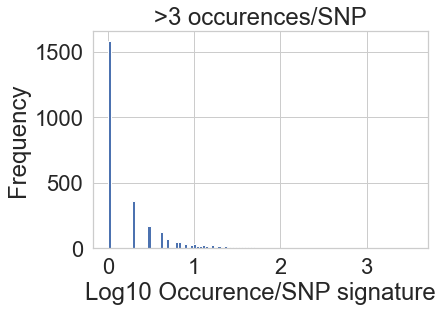

In [90]:
sns.set(style='whitegrid', font_scale=2)

fig, ax = plt.subplots(1, 1)

ax.hist(np.log10(snp_sig_count_df['taxon']), bins=100)
ax.set_xlabel('Log10 Occurence/SNP signature')
ax.set_ylabel('Frequency')
ax.set_title('>3 occurences/SNP')

plt.show()